#                                       How to Stop Telco Churn:                                    

### Zachary Stufflebeme

In [1]:
#stats model and visualization imports
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.tree import DecisionTreeClassifier,plot_tree,export_text
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
#custom Imports
from Acquire_MIRZ import get_telco_data, new_telco_data
from Prepare_MIRZ import prep_telco, split_telco, feat_dist, feat_dist_churn


# Project Plan:

## Acquire:
- I will acquire data through functions saved in my acquire.py along with my encrypted credentials.

## Prepare:
Prepare and clean my data in such a way that I can plug it in to my classification models without causing error and with the prepared data still holding true to its original meaning. This includes:
   - encoding all categorical variables
   - scaling my numeric variables to numbers between 0 and 1
   - dropping unnecessary columns
   - replacing all nulls for additional services with 0’s to indicate they don’t have the service
   - fixing empty string values in total charges with 0’s as these customers havent been charged yet



## Explore:
- Ask statistical questions of my data and create visualizations of the results in order to improve comprehension by people reading the report without clarifications from my presentation.

## Model:
- Create models and adjust parameters to try to accurately predict customer churn, Validate that all of your models are accurate not just on your train data but on outside data as well.

## Deliver:
- Put all of my findings together in a final report where I make things as easy to understand as possible. and create a csv of model predictions

## Project Summary:
- In my project I was able to create 3 models That all performed similarly well and above the baseline. I chose to isolate internet service type id , contract type id , monthly charges , and total charges as my features for my models. My random forest was my best model testing at 80% accurate at predicting customer churn with a 54% recall rate. My main take-aways from my report would be that fiber optic customers churn way more than other internet types, and from those who have fiber optic, customers that are on month to month contracts churn far more than other fiber users. some other take-aways are that I have created a model that is more accurate than the baseline and I have identified some very relevant features which we can manipulate going forward to try and reduce customer churn.

# Acquire Data:

All of the work here is done externally in my acquire.py file

In [2]:
aqTelco= get_telco_data()
aqTelco.head()

,Unnamed: 0,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service_type_id,...,signup_date,phone_service.1,multiple_lines.1,internet_service_type_id.1,online_security.1,online_backup.1,device_protection.1,tech_support.1,streaming_tv.1,streaming_movies.1
0,0,0002-ORFBO,Female,0,Yes,Yes,9,Yes,No,1,...,2021-04-21 18:07:34,Yes,No,1,No,Yes,No,Yes,Yes,No
1,1,0003-MKNFE,Male,0,No,No,9,Yes,Yes,1,...,2021-04-21 18:07:34,Yes,Yes,1,No,No,No,No,No,Yes
2,2,0004-TLHLJ,Male,0,No,No,4,Yes,No,2,...,2021-09-21 18:07:34,Yes,No,2,No,No,Yes,No,No,No
3,3,0011-IGKFF,Male,1,Yes,No,13,Yes,No,2,...,2020-12-21 18:07:34,Yes,No,2,No,Yes,Yes,No,Yes,Yes
4,4,0013-EXCHZ,Female,1,Yes,No,3,Yes,No,2,...,2021-10-21 18:07:34,Yes,No,2,No,No,No,Yes,Yes,No


This is the way the dataframe is formatted before I make any changes. I retrieved the data from our SQL database using my encrypted credentials from my env file. The data is not formatted very well for me to use our classification models and I will have to make a lot of changes.

# Prepare Data:

In [3]:
Telco = prep_telco(aqTelco)
Telco.head()

,customer_id,senior_citizen,tenure,internet_service_type_id,contract_type_id,payment_type_id,monthly_charges,total_charges,has_partner,has_dependents,has_phone_service,uses_paperless_billing,did_churn,has_mult_lines,has_online_security,has_online_backup,has_device_protection,has_tech_support,can_stream_tv,can_stream_movie
0,0002-ORFBO,0,0.125000,1,2,2,0.471144,0.068315,1,1,1,1,0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
1,0003-MKNFE,0,0.125000,1,1,2,0.414428,0.062454,0,0,1,0,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0004-TLHLJ,0,0.055556,2,1,1,0.553731,0.032338,0,0,1,1,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0011-IGKFF,1,0.180556,2,1,1,0.793532,0.142531,1,0,1,1,1,0.0,0.0,1.0,1.0,0.0,1.0,1.0
4,0013-EXCHZ,1,0.041667,2,1,2,0.653234,0.030789,1,0,1,1,1,0.0,0.0,0.0,0.0,1.0,1.0,0.0


All of the code is in my prepare.py, but in summary I:
- encoded all categorical variables
- scaled my numeric variables to numbers between 0 and 1
- dropped unnecessary columns
- replaced all nulls for additional services with 0's to indicate they don't have the service
- fixed empty string values in total charges with 0's as these customers havent been charged yet

In [4]:
#calling my split data function from my prepare in order to have training, validating, and testing portions of my data.
train, validate, test = split_telco(Telco)
user_id = pd.DataFrame()
user_id['user_id'] = test.customer_id
train = train.drop(columns = 'customer_id')
validate = validate.drop(columns = 'customer_id')
test = test.drop(columns = 'customer_id')
x_train = train.drop(columns = 'did_churn')
y_train = train.did_churn
x_validate = validate.drop(columns ='did_churn')
y_validate = validate.did_churn
x_test = test.drop(columns = 'did_churn')
y_test = test.did_churn
did_churn =  train [ train.did_churn == 1]
no_churn = train [ train.did_churn == 0]
fiber_churn = train[(train.did_churn == 1) & (train.internet_service_type_id == 2)]
fiber_no_churn = train [ (train.did_churn == 0) & ( train.internet_service_type_id == 2)]
train['contract_type'] = train.contract_type_id.map({1 : 'MTM',  2:  'one year' , 3 : 'Two year'})
train['internet_service_type'] = train.internet_service_type_id.map({1 : 'DSL',  2:  'Fiber Optic' , 3 : 'None'})
train['has_fiber'] = train.internet_service_type_id.map({1:0,2:1,3:0})
mtm = train[train.contract_type_id == 1 ]
mtm_churn = train[(train.contract_type_id == 1) & (train.did_churn == 1) ]
mtm_no_churn = train[(train.contract_type_id == 1) & (train.did_churn == 0)]
fiber = train[train.internet_service_type_id ==2]
no_fiber = train[train.internet_service_type_id != 2]


Here Ive split my data into train, validation, and testing sets in order to prevent overfitting my data. I have also made several df's isolating certain features in order to help me with my tests.


In [5]:
alpha = .05

# Data Exploration:

Distribution of Churn:

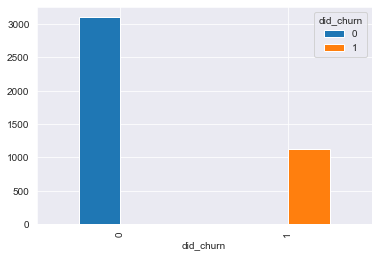

In [6]:
pd.crosstab(train.did_churn,train.did_churn).plot.bar()
plt.show()

### QUESTION 1:

 Is monthly charges the same amongst people that do and don't churn?

- Hnull - monthly charges is the same amongst people that do and dont churn.

- Halt - monthly charges is not the same amongst people that do and dont churn.

<AxesSubplot:xlabel='monthly_charges', ylabel='Count'>

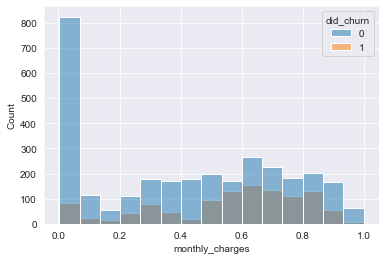

In [7]:
#Here I am creating the visualization you see below
sns.histplot(data = train, x = 'monthly_charges', hue = 'did_churn')

In [8]:
#Here I am running another T-test on churn and monthly charges.
tstat, p = stats.ttest_ind(did_churn.monthly_charges,
                no_churn.monthly_charges, 
                equal_var=False
               )
print(f'The p-value is less than the alpha: {p < alpha}')

The p-value is less than the alpha: True


Since the p-val is less than alpha we can reject the null hypothesis and can conclude that people do not churn the same amongst monthly charges and it would be a useful feature for our model.

### Question 2:

Are Fiber Optic customers more likely to churn than other customers?

- Hnull - Fiber optic customers are not more likely to churn than customers with other internet types.

- Halt - Fiber optic customers are more likely to churn than customers with other internet types.

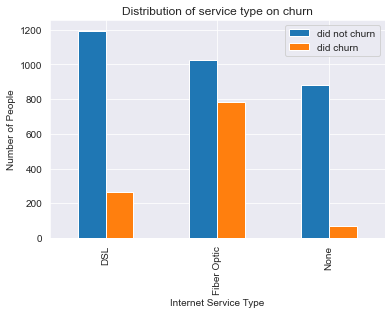

In [9]:
pd.crosstab(train['internet_service_type'], train.did_churn).plot.bar()
plt.title(f'Distribution of service type on churn')
plt.legend(['did not churn','did churn'])
plt.xlabel('Internet Service Type')
plt.ylabel('Number of People')
plt.show()
            

In [10]:
#Here I am running a t-test on different internet service types and whether or not they have churned.
tstat, p = stats.ttest_ind(did_churn.internet_service_type_id,
                no_churn.internet_service_type_id, 
                equal_var=False
               )
print(f'The p-value is less than the alpha: {p < alpha}')

The p-value is less than the alpha: True


Since the P-val is less than the alpha we can conclude that Fiber optic customers churn more and that the internet service type is statistically significant in determining churn and should be considered for our model.

### Question 3:

Do fiber users on month to month plans churn more than fiber users on other plans?

- Hnull - Fiber users on month to month plans do not churn more than fiber users on other billing plans.

- Halt - Fiber users on month to month plans do churn more than fiber users on other billing plans

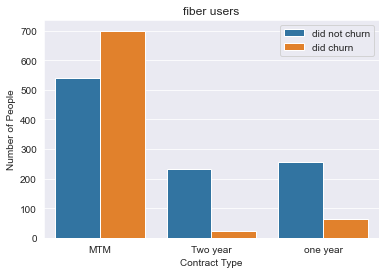

In [11]:
fiber = train[train.internet_service_type == 'Fiber Optic']
sns.countplot( data = fiber, x = 'contract_type', hue = 'did_churn')
plt.title('fiber users')
plt.legend(['did not churn', 'did churn'])
plt.xlabel('Contract Type')
plt.ylabel('Number of People')
plt.show()

In [12]:
tstat, p = stats.ttest_ind(fiber_churn.contract_type_id,
                fiber_no_churn.contract_type_id, 
                equal_var=False
               )
print(f'The p-value is less than the alpha: {p < alpha}')

The p-value is less than the alpha: True


Since the P-val is less than alpha we can conclude that contract type has a statistical significance in determining whether fiber optic users will or won't churn.

### Question 4:

Do month to month users with fiber churn more than month to month users without fiber?

- Hnull - month to month users without fiber are churning the same amount as month to month users with fiber

- Halt - month-to-month users without fiber are churning less than month-to-month users with fiber

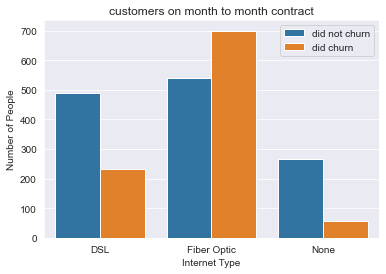

In [13]:
mtm = train[train.contract_type_id == 1 ]
sns.countplot(data = mtm, x = 'internet_service_type', hue = 'did_churn')
plt.title('customers on month to month contract')
plt.legend(['did not churn','did churn'])
plt.xlabel('Internet Type')
plt.ylabel('Number of People')
plt.show()

In [14]:
tstat, p = stats.ttest_ind(mtm_churn.has_fiber,
                mtm_no_churn.has_fiber, 
                equal_var=False
               )
print(f'The p-value is less than the alpha: {p < alpha}')

The p-value is less than the alpha: True


Since p-val less than alpha we can conclude mtm users with fiber are churning more frequently than mtm users without fiber.

After exploring these are the features I've decided to move forward with in my modeling
-monthly charges
-internet service type id
-contract type id
-total charges



In [15]:
imp = ['internet_service_type_id','contract_type_id','monthly_charges','total_charges']
xmodelTrain = train[imp]
xmodelValidate = validate[imp]
xmodelTest = test[imp]

### Models and Evaluation:
- Decision Tree Classifier
- Random Forest
- Logistic Regression

My goal for the models will be to improve upon my baseline accuracy which is 73%

In [16]:
#Here I am calculating our baseline accuracy
baseline_accuracy = round((train.did_churn == 0).mean(), 4) * 100
baseline_accuracy

73.47

## Decision Tree Model

Best max_depth = 5

In [17]:
#Here I am creating fitting and scoring my Decision Tree Model
DTC = DecisionTreeClassifier(max_depth = 5, random_state = 123)
DTC.fit(xmodelTrain,y_train)
DTC.score(xmodelValidate,y_validate) * 100

77.9985805535841

In [18]:
y_preds = pd.DataFrame({
    'y_act': y_validate,
    'baseline': 0,
    'DTC': DTC.predict(xmodelValidate)})
pd.DataFrame(classification_report(y_preds.y_act, y_preds.DTC, output_dict=True))


,0,1,accuracy,macro avg,weighted avg
precision,0.808511,0.636752,0.779986,0.722631,0.762920
recall,0.917874,0.398396,0.779986,0.658135,0.779986
f1-score,0.859729,0.490132,0.779986,0.674930,0.761624
support,1035.000000,374.000000,0.779986,1409.000000,1409.000000


I found my best Decision Tree at a max depth of 5 which gave me a 77.99 % accuracy and a 39.84% recall on validate. This surpasses my baseline by around 5 %.

## Random Forest Model:

Best Hyperparameters: max_depth = 10 min_leaf = 12

In [19]:
#Here I am creating fitting and scoring my Decision Tree Model on Validate data.
rf = RandomForestClassifier(max_depth = 10, min_samples_leaf = 12,random_state = 123)
rf.fit(xmodelTrain,y_train)
rf.score(xmodelValidate,y_validate) * 100

78.708303761533

In [20]:
y_preds = pd.DataFrame({
    'y_act': y_validate,
    'baseline': 0,
    'rf': rf.predict(xmodelValidate)})
pd.DataFrame(classification_report(y_preds.y_act, y_preds.rf, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.832579,0.621711,0.787083,0.727145,0.776607
recall,0.888889,0.505348,0.787083,0.697118,0.787083
f1-score,0.859813,0.557522,0.787083,0.708668,0.779574
support,1035.000000,374.000000,0.787083,1409.000000,1409.000000


I found my best Random Forest model at a max depth of 10 and min sample leaf 12. This gave me a 78.7 % accuracy and 51% recall on validate. This model surpasses my baseline by nearly 6 percent and the higher recall is also an improvement compared to my best decision tree model

## Logistic Regression:

best hyperparameter: c = .2

In [21]:
#Here I am creating fitting and scoring my Decision Tree Model on Validate data.
logreg = LogisticRegression(C = .2,random_state = 123)
logreg.fit(xmodelTrain,y_train)
logreg.score(xmodelValidate,y_validate) * 100

78.28246983676365

In [22]:
y_preds = pd.DataFrame({
    'y_act': y_validate,
    'baseline': 0,
    'logreg': logreg.predict(xmodelValidate)})
pd.DataFrame(classification_report(y_preds.y_act, y_preds.logreg, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.822281,0.622302,0.782825,0.722292,0.769199
recall,0.898551,0.462567,0.782825,0.680559,0.782825
f1-score,0.858726,0.530675,0.782825,0.694700,0.771649
support,1035.000000,374.000000,0.782825,1409.000000,1409.000000


I found my best logistic regression model at a c value of .2. This gave me a 78.28 % accuracy and a 46.26 % accuracy. both the accuracy and recall of my random forest beat this model. Therefor my random forest is the model I will be going forward with.

In [23]:
#Here I am providing a classification report of how my best model performs on my test data
predicted_test = rf.predict(xmodelTest)
print(classification_report(y_test, rf.predict(xmodelTest)))


              precision    recall  f1-score   support

           0       0.84      0.89      0.87      1035
           1       0.64      0.54      0.59       374

    accuracy                           0.80      1409
   macro avg       0.74      0.72      0.73      1409
weighted avg       0.79      0.80      0.79      1409



As you can see my random forest model tests at 80% accuracy this is about 7% above my baseline. we also see that the model tests with a 54% recall which is good as we want to reduce the amount of missed churners and wouldn't mind misidentifying some customers that won't churn as churners.

## Creating Predictions CSV

In [24]:
prob_test = logreg.predict_proba(xmodelTest)
#Here I am getting predicted probablity of churn for my telco.csv
preds_df = pd.DataFrame(prob_test, columns= logreg.classes_.tolist())
preds_df = preds_df.rename(columns={0 : 'No Churn', 1: 'Churn'})
preds_df = preds_df.drop(columns = 'No Churn')
preds_df

,Churn
0,0.025986
1,0.407603
2,0.564255
3,0.132723
4,0.644522
...,...
1404,0.111176
1405,0.570429
1406,0.531393
1407,0.238390


In [25]:
reset_test = test.reset_index()

In [26]:
#Here I merge the df to my probabilities
test_prob_df = pd.concat([reset_test, preds_df], axis=1)


In [27]:
test_prob_df['predicted'] = predicted_test

In [28]:
test_prob_df.set_index("index", inplace = True)

In [29]:
csv_df = test_prob_df[[ 'Churn', 'predicted']]

In [30]:
csv_df = pd.concat([user_id, csv_df], axis=1)

In [31]:
csv_df.head()

,user_id,Churn,predicted
3115,3486-HOOGQ,0.025986,0
1581,6080-TCMYC,0.407603,0
6863,3627-FHKBK,0.564255,1
3541,6408-OTUBZ,0.132723,0
846,2929-ERCFZ,0.644522,1


In [32]:
csv_df.to_csv('predictions.csv')

## Conclusion:

 In conclusion I found 4 important features to focus on in the name of reducing churn, and created a few good models that beat the baseline and one that even broke through 80%. In the future I would like a little more time to tamper with the features I include in my models as I believe doing do could garner further gains in accuracy.

## Business Reccomendations:

Based off of my exploration I would recommend that we stop offering fiber optic to customers on month to month contracts as customers who check both of those boxes are very highly associated with churning. offering fiber optic to customers on longer contracts would help keep them with the company for longer however in order to keep them for the long haul we will have to either decrease the price of fiber optic or give fiber customers additional services to add value to their contracts.